In [11]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize
from standard_plotting import set_size

In [12]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.rcParams.update(tex_fonts)

outdir = "/groups/icecube/peter/workspace/analyses/multiclassification_track_cascade_neutrinos/plots/monte_carlo_results/"

In [13]:
indir_MC_139008_muons_neutrinos_and_noise = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"
# indir_MC_130000_muons_neutrinos_and_noise = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Old_muon_more_noise_Monte_Carlo_all_events_all_variables.csv"


In [14]:
# use_130000_muons = True
# use_lvl3_cuts = True
# Neutrino_cut = 12
# track_cut = 0.9
# cascade_cut = 0.5
# with_MC_truth = True
# scale_MC_to_RD_in_comparison_plots = True

use_cols_MC = ['track_mu_pred', 'event_no', 'energy_pred', 'zenith_pred',
       'zenith_kappa', 'azimuth_pred', 'azimuth_kappa', 'pid_neutrino_pred','pid_noise_pred','pid_muon_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'total_osc_weight',
       'L3_oscNext_bool', 'azimuth', 'zenith', 'energy', 'position_z',
       'position_y', 'position_x', 'track_mu']


In [15]:
MC_139008 = pd.read_csv(indir_MC_139008_muons_neutrinos_and_noise,usecols=use_cols_MC).sort_values('event_no').reset_index(drop = True)
MC = MC_139008

In [16]:
multiclass_electron_neutrinos = MC[MC['pid'].isin((12,-12))]
multiclass_muon_neutrinos = MC[MC['pid'].isin((14,-14))]
multiclass_tau_neutrinos = MC[MC['pid'].isin((16,-16))]
multiclass_muons = MC[MC['pid'].isin((13,-13))]
multiclass_noise = MC[MC['pid'].isin((1,-1))]


multiclass_equal_comparison_list = []
multiclass_equal_comparison_list.extend(multiclass_electron_neutrinos['event_no'].to_list()[:int(169373/3)])
multiclass_equal_comparison_list.extend(multiclass_muon_neutrinos['event_no'].to_list()[:int(169373/3)])
multiclass_equal_comparison_list.extend(multiclass_tau_neutrinos['event_no'].to_list()[:int(169373/3)])
multiclass_equal_comparison_list.extend(multiclass_noise['event_no'].to_list()[:169373])
multiclass_equal_comparison_list.extend(multiclass_muons['event_no'].to_list()[:169373])
multiclass_equal_comparison = MC[MC['event_no'].isin(multiclass_equal_comparison_list)]

print(np.shape(MC))
print(np.shape(multiclass_equal_comparison))

(37235782, 24)
(508117, 24)


In [17]:
pid_transform = {1:0,12:2,13:1,14:2,16:2}

predictions = []
truth = []


number = len(multiclass_equal_comparison)

for i in range(number):# range(len(results)):
    noise_pred = multiclass_equal_comparison['pid_noise_pred'].values[i]
    muon_pred = multiclass_equal_comparison['pid_muon_pred'].values[i]
    neutrino_pred = multiclass_equal_comparison['pid_neutrino_pred'].values[i]
    predictions.append(np.argmax([noise_pred,muon_pred,neutrino_pred]))

    truth.append(pid_transform[abs(multiclass_equal_comparison['pid'].values[i])])


confusion_matrix = metrics.confusion_matrix(truth, predictions)

mask_noise = [True if truth[i] ==0 else False for i in range(len(truth))]
mask_muon = [True if truth[i] ==1 else False for i in range(len(truth))]
mask_neutrino = [True if truth[i] ==2 else False for i in range(len(truth))]


fpr_neutrino, tpr_neutrino , _ = metrics.roc_curve(truth,multiclass_equal_comparison['pid_neutrino_pred'].values,pos_label=2)
fpr_muon, tpr_muon , _ = metrics.roc_curve(truth,multiclass_equal_comparison['pid_muon_pred'].values,pos_label=1)
fpr_noise, tpr_noise , _ = metrics.roc_curve(truth,multiclass_equal_comparison['pid_noise_pred'].values,pos_label=0)

auc_neutrino = metrics.auc(fpr_neutrino, tpr_neutrino)
auc_muon = metrics.auc(fpr_muon, tpr_muon)
auc_noise = metrics.auc(fpr_noise, tpr_noise)

/tmp/ipykernel_18980/4239578435.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


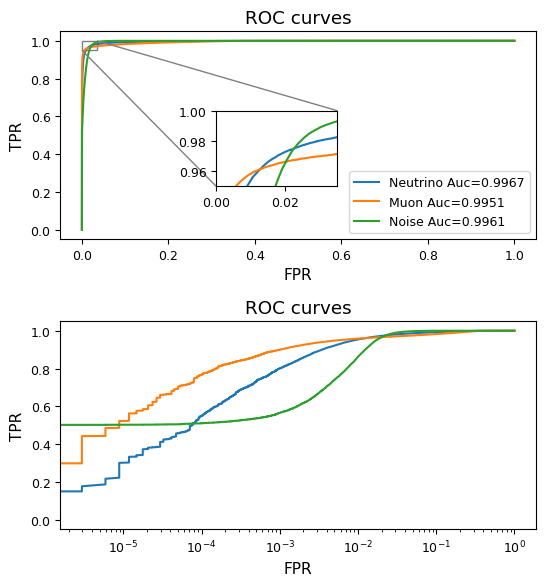

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# fig, axs = plt.subplots(figsize=set_size('thesis'))
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Noise','Muons','Neutrinos'])
# cm_display.plot(ax=axs)

# for labels in cm_display.text_.ravel():
#     labels.set_fontsize(9)
# axs.set_ylabel('True')
# axs.set_xlabel('Predicted')


#fig.savefig(outdir+ 'Confusion_matrix_Multiclass_MC.pdf', format='pdf', bbox_inches='tight')


fig, axs = plt.subplots(2,1,figsize=set_size('thesis',subplots=(2, 1),y_size=6))

axs[0].plot(fpr_neutrino, tpr_neutrino, label=f'Neutrino Auc={auc_neutrino:.4f}')
axs[0].plot(fpr_muon, tpr_muon, label=f'Muon Auc={auc_muon:.4f}')
axs[0].plot(fpr_noise, tpr_noise, label=f'Noise Auc={auc_noise:.4f}')


axins = zoomed_inset_axes(axs[0], zoom=8, loc='lower right',bbox_to_anchor=(350,400)) # zoom = 6
axins.plot(fpr_neutrino, tpr_neutrino, label=f'Neutrino Auc={auc_neutrino:.4f}')
axins.plot(fpr_muon, tpr_muon, label=f'Muon Auc={auc_muon:.4f}')
axins.plot(fpr_noise, tpr_noise, label=f'Noise Auc={auc_noise:.4f}')

axins.set_xlim(0,0.035)
axins.set_ylim(0.95,1)
# plt.xticks(visible=False)
# plt.yticks(visible=False)
mark_inset(axs[0], axins, loc1=1, loc2=3, fc="none", ec="0.5")
#plt.setp(axins, xticks=[], yticks=[])

axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
#axs[0].set_xscale('log')
axs[0].set_title('ROC curves')
axs[0].legend(loc='lower right')

axs[1].plot(fpr_neutrino, tpr_neutrino, label=f'Neutrino Auc={auc_neutrino:.4f}')
axs[1].plot(fpr_muon, tpr_muon, label=f'Muon Auc={auc_muon:.4f}')
axs[1].plot(fpr_noise, tpr_noise, label=f'Noise Auc={auc_noise:.4f}')
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].set_xscale('log')
axs[1].set_title('ROC curves')
#axs[1].legend()

fig.tight_layout()
fig.savefig(outdir+ 'ROC_Curves_Multiclass_MC.png', format='png', bbox_inches='tight',dpi=200)

#fig.savefig(outdir + 'Roc_curves.png')

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


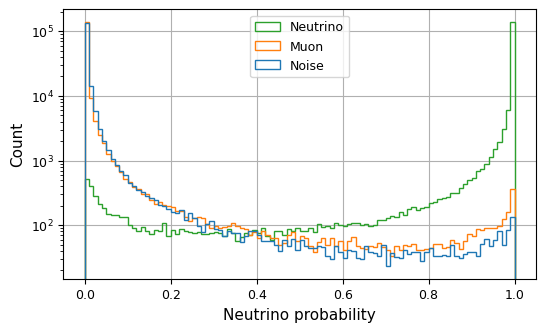

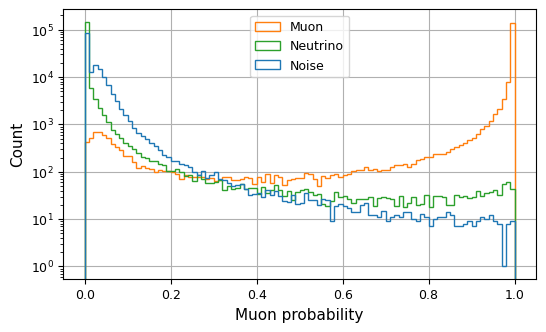

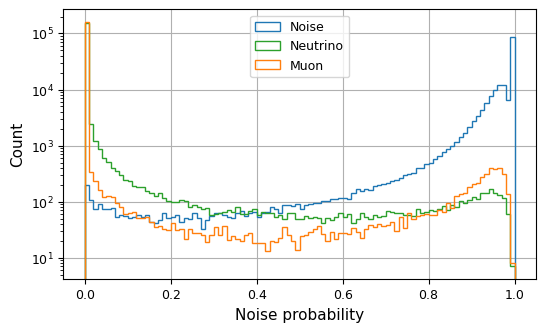

In [19]:
noise_mask = multiclass_equal_comparison['pid'].isin([-1,1])
muon_mask = multiclass_equal_comparison['pid'].isin([-13,13])
neutrino_mask = multiclass_equal_comparison['pid'].isin([-12,12,-14,14,-16,16])

bins_to_use = np.linspace(0,1,101)
print(bins_to_use)
fig, axs = plt.subplots(figsize=set_size('thesis'))

plot_neutrino = [multiclass_equal_comparison['pid_neutrino_pred'][noise_mask],multiclass_equal_comparison['pid_neutrino_pred'][muon_mask],multiclass_equal_comparison['pid_neutrino_pred'][neutrino_mask]]
axs.hist(plot_neutrino, bins_to_use, density=False, histtype='step',stacked=False,label=['Noise','Muon','Neutrino'],color=['C0','C1','C2'])

#axs.set_title('Test set results')
axs.set_xlabel('Neutrino probability')
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend()
axs.grid()
#axs.set_ylim(bottom=1)
fig.tight_layout()
fig.savefig(outdir+ 'neutrino_prob_Multiclass_MC.png', format='png', bbox_inches='tight',dpi=200)


fig, axs = plt.subplots(figsize=set_size('thesis'))
plot_neutrino = [multiclass_equal_comparison['pid_muon_pred'][noise_mask],multiclass_equal_comparison['pid_muon_pred'][neutrino_mask],multiclass_equal_comparison['pid_muon_pred'][muon_mask]]
axs.hist(plot_neutrino, bins_to_use, density=False, histtype='step',stacked=False,label=['Noise','Neutrino','Muon'],color=['C0','C2','C1'])

#axs.set_title('Test set results')
axs.set_xlabel('Muon probability')
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend()
#axs.set_ylim(bottom=1)
axs.grid()
fig.tight_layout()
fig.savefig(outdir+ 'muon_prob_Multiclass_MC.png', format='png', bbox_inches='tight',dpi=200)


fig, axs = plt.subplots(figsize=set_size('thesis'))
plot_neutrino = [multiclass_equal_comparison['pid_noise_pred'][muon_mask],multiclass_equal_comparison['pid_noise_pred'][neutrino_mask],multiclass_equal_comparison['pid_noise_pred'][noise_mask]]
axs.hist(plot_neutrino, bins_to_use, density=False, histtype='step',stacked=False,label=['Muon','Neutrino','Noise'],color=['C1','C2','C0'])

#axs.set_title('Test set results')
axs.set_xlabel('Noise probability')
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend()
axs.grid()
#axs.set_ylim(bottom=1)

fig.tight_layout()
fig.savefig(outdir+ 'noise_prob_Multiclass_MC.png', format='png', bbox_inches='tight',dpi=200)

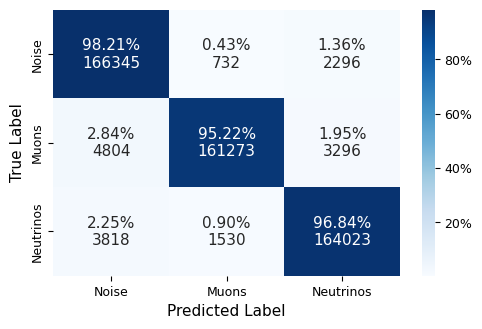

In [20]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
    }   

    plt.rcParams.update(tex_fonts)
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    #sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d' % (p, c)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    fig.savefig(outdir+ 'confusion_matrix_Multiclass_MC.png', format='png', bbox_inches='tight',dpi=200)
    #plt.savefig(filename,  bbox_inches='tight')

cm_analysis(truth, predictions,'confusion_matrix',[0,1,2],['Noise','Muons','Neutrinos'],figsize=set_size('thesis'))

In [21]:
MC = MC[MC['pid'].isin((-12,12,-14,14,-16,16))]

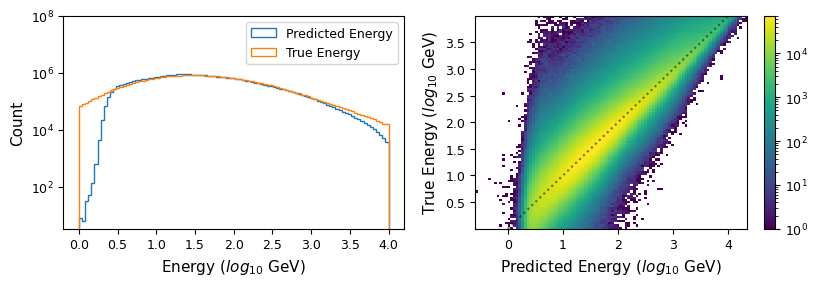

In [22]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_energy = np.linspace(0,4,100)
hist = axs[0].hist(np.log10(MC['energy_pred']),bins=bins_energy,label='Predicted Energy',alpha=1,histtype='step')
hist = axs[0].hist(np.log10(MC['energy']),bins=bins_energy,label='True Energy',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Energy ($log_{10}$ GeV)')
axs[0].set_yscale('log')
axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(np.log10(MC['energy_pred']),np.log10(MC['energy']),bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True Energy ($log_{10}$ GeV)')
axs[1].set_xlabel(r'Predicted Energy ($log_{10}$ GeV)')
energy_line = np.linspace(0,4,100)
axs[1].plot(energy_line,energy_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'Energy_result_MC.png', format='png', bbox_inches='tight',dpi=200)

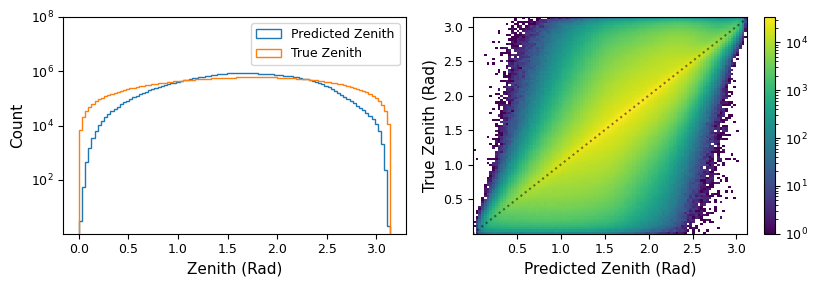

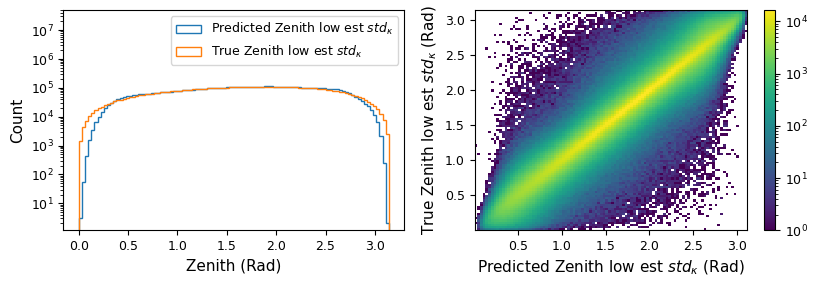

In [23]:
kappa_cut = 20
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_zenith = np.linspace(0,np.pi,100)
hist = axs[0].hist(MC['zenith_pred'],bins=bins_zenith,label='Predicted Zenith',alpha=1,histtype='step')
hist = axs[0].hist(MC['zenith'],bins=bins_zenith,label='True Zenith',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Zenith (Rad)')
axs[0].set_yscale('log')
axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(MC['zenith_pred'],MC['zenith'],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True Zenith (Rad)')
axs[1].set_xlabel(r'Predicted Zenith (Rad)')
zenith_line = np.linspace(0,np.pi,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'zenith_result_MC.png', format='png', bbox_inches='tight',dpi=200)


fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_zenith = np.linspace(0,np.pi,100)
hist = axs[0].hist(MC['zenith_pred'][MC['zenith_kappa']>kappa_cut],bins=bins_zenith,label=r'Predicted Zenith low est $std_{\kappa}$',alpha=1,histtype='step')
hist = axs[0].hist(MC['zenith'][MC['zenith_kappa']>kappa_cut],bins=bins_zenith,label=r'True Zenith low est $std_{\kappa}$',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Zenith (Rad)')
axs[0].set_yscale('log')
axs[0].set_ylim(top=5*10**7)
axs[0].legend()

hist = axs[1].hist2d(MC['zenith_pred'][MC['zenith_kappa']>kappa_cut],MC['zenith'][MC['zenith_kappa']>kappa_cut],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True Zenith low est $std_{\kappa}$ (Rad)')
axs[1].set_xlabel(r'Predicted Zenith low est $std_{\kappa}$ (Rad)')

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'zenith_result_kappa_cut_MC.png', format='png', bbox_inches='tight',dpi=200)

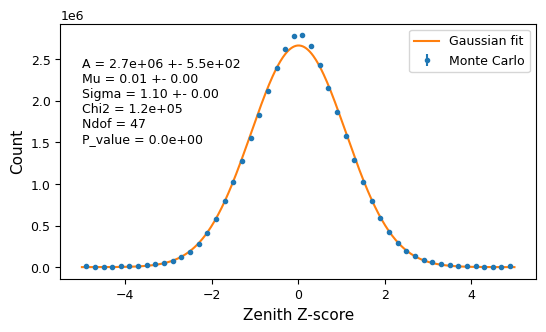

In [24]:
import scipy.stats as sci
from scipy.optimize import curve_fit

zenith_residuals = MC['zenith_pred']-MC['zenith']
zenith_z_score = zenith_residuals/(1/np.sqrt(MC['zenith_kappa']))

bins_zenith = np.linspace(-5,5,51)
bins_zenith_middle = (bins_zenith[1:] + bins_zenith[:-1])/2

counts_zenith_z_score,_ = np.histogram(np.clip(zenith_z_score,-5,5),bins=bins_zenith)

sigma_zenith_z_score = np.sqrt(counts_zenith_z_score)


def gauss(x,A,mu,sigma):
    return A*np.exp(-(x - mu)**2/(2*sigma**2)) 

guess = [2.5*10**6,0,1]

par, C = curve_fit(gauss, bins_zenith_middle, ydata=counts_zenith_z_score, sigma=sigma_zenith_z_score, p0=guess, absolute_sigma=True) 
C = np.sqrt(np.diag(C))

fig, axs = plt.subplots(1,1,figsize=set_size('thesis'))



hist = axs.errorbar(bins_zenith_middle,counts_zenith_z_score,yerr=sigma_zenith_z_score,fmt='.',label='Monte Carlo')

x_plot = np.linspace(-5,5,500)
y_plot = gauss(x_plot,par[0],par[1],par[2])
axs.plot(x_plot,y_plot,label='Gaussian fit')

y = gauss(bins_zenith_middle,par[0],par[1],par[2])
chi2_zenith = np.sum((counts_zenith_z_score-y)**2/sigma_zenith_z_score**2)
ndof_zenith = len(counts_zenith_z_score)-len(par)
p_value_zenith = sci.chi2.sf(chi2_zenith,ndof_zenith)

string = "A = {:.1e} +- {:.1e}\nMu = {:.2f} +- {:.2f}\nSigma = {:.2f} +- {:.2f}\nChi2 = {:.1e}\nNdof = {:.0f}\nP_value = {:.1e}".format(par[0],C[0],par[1],C[1],par[2],C[2],chi2_zenith,ndof_zenith,p_value_zenith)
# string = "Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}".format()
axs.text(-5, 1.5*10**6, string,fontsize=9)



axs.set_ylabel('Count')
axs.set_xlabel('Zenith Z-score')
#axs.set_yscale('log')
#axs.set_ylim(top=5**8)
axs.legend()



fig.tight_layout()
fig.savefig(outdir+ 'PULL_zenith_result_MC.png', format='png', bbox_inches='tight',dpi=200)

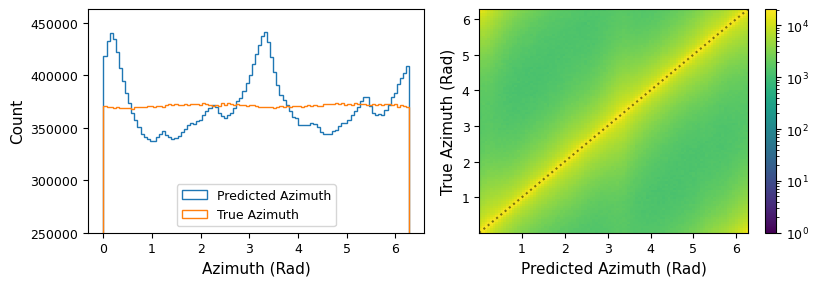

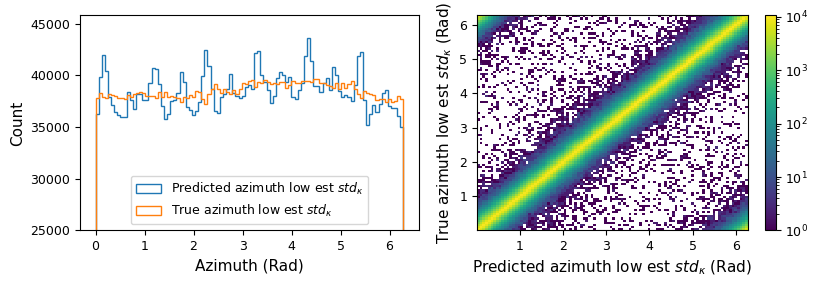

In [25]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_azimuth = np.linspace(0,2*np.pi,100)
hist = axs[0].hist(MC['azimuth_pred'],bins=bins_azimuth,label='Predicted Azimuth',alpha=1,histtype='step')
hist = axs[0].hist(MC['azimuth'],bins=bins_azimuth,label='True Azimuth',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Azimuth (Rad)')
#axs[0].set_yscale('log')
axs[0].set_ylim(bottom=250000)
axs[0].legend(loc='lower center')

hist = axs[1].hist2d(MC['azimuth_pred'],MC['azimuth'],bins=100,norm = colors.LogNorm(vmin=1))
axs[1].set_ylabel(r'True Azimuth (Rad)')
axs[1].set_xlabel(r'Predicted Azimuth (Rad)')
zenith_line = np.linspace(0,2*np.pi,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'azimuth_result_MC.png', format='png', bbox_inches='tight',dpi=200)


fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_azimuth = np.linspace(0,2*np.pi,100)
hist = axs[0].hist(MC['azimuth_pred'][MC['azimuth_kappa']>kappa_cut],bins=bins_azimuth,label=r'Predicted azimuth low est $std_{\kappa}$',alpha=1,histtype='step')
hist = axs[0].hist(MC['azimuth'][MC['azimuth_kappa']>kappa_cut],bins=bins_azimuth,label=r'True azimuth low est $std_{\kappa}$',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Azimuth (Rad)')
#axs[0].set_yscale('log')
axs[0].set_ylim(bottom=25000)
axs[0].legend(loc='lower center')

hist = axs[1].hist2d(MC['azimuth_pred'][MC['azimuth_kappa']>kappa_cut],MC['azimuth'][MC['azimuth_kappa']>kappa_cut],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True azimuth low est $std_{\kappa}$ (Rad)')
axs[1].set_xlabel(r'Predicted azimuth low est $std_{\kappa}$ (Rad)')

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'azimuth_result_kappa_cut_MC.png', format='png', bbox_inches='tight',dpi=200)

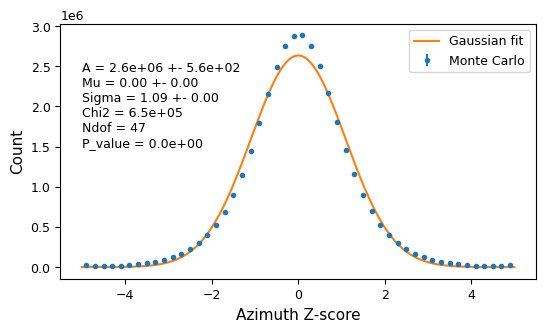

In [26]:
import scipy.stats as sci
from scipy.optimize import curve_fit

azimuth_residuals = MC['azimuth_pred']-MC['azimuth']
azimuth_residuals[azimuth_residuals<-np.pi] = 2*np.pi + azimuth_residuals[azimuth_residuals<-np.pi]
azimuth_residuals[azimuth_residuals>np.pi] = -2*np.pi + azimuth_residuals[azimuth_residuals>np.pi]

azimuth_z_score = azimuth_residuals/(1/np.sqrt(MC['azimuth_kappa']))

bins_azimuth = np.linspace(-5,5,51)
bins_azimuth_middle = (bins_azimuth[1:] + bins_azimuth[:-1])/2

counts_azimuth_z_score,_ = np.histogram(np.clip(azimuth_z_score,-5,5),bins=bins_azimuth)

sigma_azimuth_z_score = np.sqrt(counts_azimuth_z_score)


def gauss(x,A,mu,sigma):
    return A*np.exp(-(x - mu)**2/(2*sigma**2)) 

guess = [2.5*10**6,0,1]

par, C = curve_fit(gauss, bins_azimuth_middle, ydata=counts_azimuth_z_score, sigma=sigma_azimuth_z_score, p0=guess, absolute_sigma=True) 
C = np.sqrt(np.diag(C))

fig, axs = plt.subplots(1,1,figsize=set_size('thesis'))



hist = axs.errorbar(bins_azimuth_middle,counts_azimuth_z_score,yerr=sigma_azimuth_z_score,fmt='.',label='Monte Carlo')

x_plot = np.linspace(-5,5,500)
y_plot = gauss(x_plot,par[0],par[1],par[2])
axs.plot(x_plot,y_plot,label='Gaussian fit')

y = gauss(bins_azimuth_middle,par[0],par[1],par[2])
chi2_azimuth = np.sum((counts_azimuth_z_score-y)**2/sigma_azimuth_z_score**2)
ndof_azimuth = len(counts_azimuth_z_score)-len(par)
p_value_azimuth = sci.chi2.sf(chi2_azimuth,ndof_azimuth)

string = "A = {:.1e} +- {:.1e}\nMu = {:.2f} +- {:.2f}\nSigma = {:.2f} +- {:.2f}\nChi2 = {:.1e}\nNdof = {:.0f}\nP_value = {:.1e}".format(par[0],C[0],par[1],C[1],par[2],C[2],chi2_azimuth,ndof_azimuth,p_value_azimuth)
# string = "Chi2 = {:.1f}\nNdof = {}\nP-value = {:.1e}".format()
axs.text(-5, 1.5*10**6, string,fontsize=9)



axs.set_ylabel('Count')
axs.set_xlabel('Azimuth Z-score')
#axs.set_yscale('log')
#axs.set_ylim(top=5**8)
axs.legend()



fig.tight_layout()
fig.savefig(outdir+ 'PULL_azimuth_result_MC.png', format='png', bbox_inches='tight',dpi=200)


In [27]:
print(len(MC[MC['track_mu']==1]))
print(len(MC[MC['track_mu']==0]))

18054122
18690820


In [28]:
outdir_interaction_type = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/Test_set/"
MC_interaction_type = pd.read_csv(outdir_interaction_type + 'interaction_type_New_muon_test.csv')

In [29]:
CC_neutrino_event_nos = MC_interaction_type['event_no'][MC_interaction_type['interaction_type']==1]
NC_neutrino_event_nos = MC_interaction_type['event_no'][MC_interaction_type['interaction_type']==2]

electron_CC_neutrinos = multiclass_electron_neutrinos['event_no'][multiclass_electron_neutrinos['event_no'].isin(CC_neutrino_event_nos.to_list())]
electron_NC_neutrinos = multiclass_electron_neutrinos['event_no'][multiclass_electron_neutrinos['event_no'].isin(NC_neutrino_event_nos.to_list())]
muon_CC_neutrinos = multiclass_muon_neutrinos['event_no'][multiclass_muon_neutrinos['event_no'].isin(CC_neutrino_event_nos.to_list())]
muon_NC_neutrinos = multiclass_muon_neutrinos['event_no'][multiclass_muon_neutrinos['event_no'].isin(NC_neutrino_event_nos.to_list())]
tau_CC_neutrinos = multiclass_tau_neutrinos['event_no'][multiclass_tau_neutrinos['event_no'].isin(CC_neutrino_event_nos.to_list())]
tau_NC_neutrinos = multiclass_tau_neutrinos['event_no'][multiclass_tau_neutrinos['event_no'].isin(NC_neutrino_event_nos.to_list())]

these are for all test events!


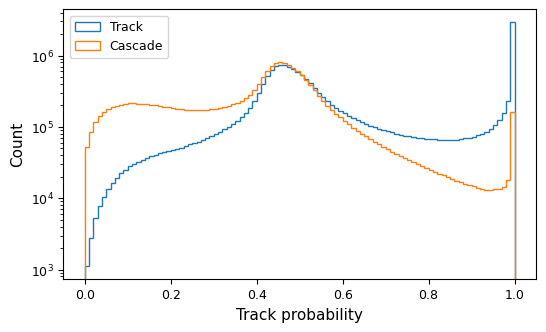

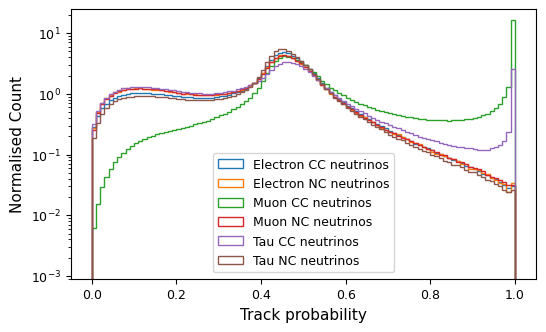

In [30]:
print('these are for all test events!')

fig, axs = plt.subplots(figsize=set_size('thesis'))
#print(track_cascade.head(10))
hist = axs.hist(MC['track_mu_pred'][MC['track_mu'] == 1],bins=100,alpha=1,label='Track',histtype='step')
hist = axs.hist(MC['track_mu_pred'][MC['track_mu'] == 0],bins=100,alpha=1,label='Cascade',histtype='step')

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Track probability')
axs.legend(loc='upper left')

fig.tight_layout()

fig, axs = plt.subplots(figsize=set_size('thesis'))
#print(track_cascade.head(10))
hist = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(electron_CC_neutrinos.to_list())],bins=100,alpha=1,label='Electron CC neutrinos',histtype='step',density=True)
hist = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(electron_NC_neutrinos.to_list())],bins=100,alpha=1,label='Electron NC neutrinos',histtype='step',density=True)
hist = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(muon_CC_neutrinos.to_list())],bins=100,alpha=1,label='Muon CC neutrinos',histtype='step',density=True)
hist = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(muon_NC_neutrinos.to_list())],bins=100,alpha=1,label='Muon NC neutrinos',histtype='step',density=True)
hist_tau_CC = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(tau_CC_neutrinos.to_list())],bins=100,alpha=1,label='Tau CC neutrinos',histtype='step',density=True)
hist = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(tau_NC_neutrinos.to_list())],bins=100,alpha=1,label='Tau NC neutrinos',histtype='step',density=True)

axs.set_yscale('log')
axs.set_ylim(bottom=0.9*10**-3)
axs.set_ylabel('Normalised Count')
axs.set_xlabel('Track probability')
axs.legend(loc='lower center')

fig.tight_layout()
fig.savefig(outdir + 'track_probability_MC_each_type.png',bbox_inches='tight',dpi=200)

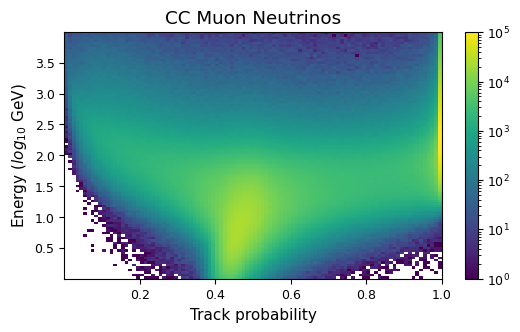

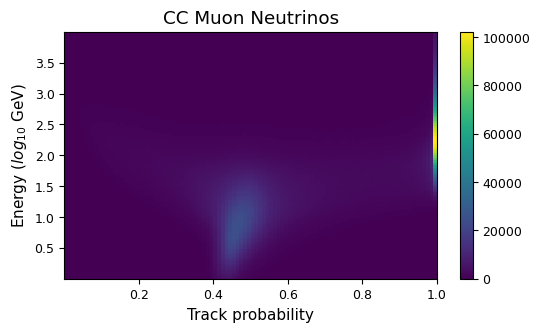

In [31]:
fig, axs = plt.subplots(figsize=set_size('thesis'))

hist = axs.hist2d(MC['track_mu_pred'][MC['event_no'].isin(muon_CC_neutrinos.to_list())],np.log10(MC['energy'][MC['event_no'].isin(muon_CC_neutrinos.to_list())]),bins=100,norm = colors.LogNorm())
axs.set_xlabel(r'Track probability')
axs.set_ylabel(r'Energy ($log_{10}$ GeV)')
axs.set_title(r'CC Muon Neutrinos')

fig.colorbar(hist[3],ax=axs)
fig.tight_layout()
fig.savefig(outdir + 'track_probability_muon_neutrino_vs_energy.png',bbox_inches='tight',dpi=200)

fig, axs = plt.subplots(figsize=set_size('thesis'))

hist = axs.hist2d(MC['track_mu_pred'][MC['event_no'].isin(muon_CC_neutrinos.to_list())],np.log10(MC['energy'][MC['event_no'].isin(muon_CC_neutrinos.to_list())]),bins=100)
axs.set_xlabel(r'Track probability')
axs.set_ylabel(r'Energy ($log_{10}$ GeV)')
axs.set_title(r'CC Muon Neutrinos')

fig.colorbar(hist[3],ax=axs)
fig.tight_layout()

In [32]:
counts_tau_CC,_,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(tau_CC_neutrinos.to_list())],bins=100,alpha=1,label='Tau CC neutrinos',histtype='step',density=True)
counts_tau_NC,_,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(tau_NC_neutrinos.to_list())],bins=100,alpha=1,label='Tau CC neutrinos',histtype='step',density=True)
counts_mu_CC,_,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(muon_CC_neutrinos.to_list())],bins=100,alpha=1,label='Tau CC neutrinos',histtype='step',density=True)
counts_mu_NC,_,_ = axs.hist(MC['track_mu_pred'][MC['event_no'].isin(muon_NC_neutrinos.to_list())],bins=100,alpha=1,label='Tau CC neutrinos',histtype='step',density=True)


In [33]:
print(counts_tau_CC[-1])
print(counts_tau_NC[-1])
print(counts_mu_CC[-1])
print(counts_mu_NC[-1])

2.5166140222017988
0.025741751359631547
16.485449641279896
0.03193372373817177


In [34]:
print(counts_tau_CC[-1]/counts_tau_NC[-1])
print(counts_mu_CC[-1]/counts_mu_NC[-1])

97.76390063919179
516.2395020526253


In [35]:
print((counts_tau_CC[-1]/counts_tau_NC[-1])/(counts_mu_CC[-1]/counts_mu_NC[-1]))
print((counts_tau_CC[-1]/counts_mu_CC[-1]))

0.18937702413409224
0.15265668070709743


In [36]:
print(np.sum(counts_tau_CC[-10:])/np.sum(counts_tau_CC[:]))
print(np.sum(counts_tau_NC[-10:])/np.sum(counts_tau_NC[:]))

0.03799341540317582
0.003532507448562694


In [37]:
print('Now for a Track/cascade test set, which has equal types!')
print(len(electron_CC_neutrinos))
print(len(electron_NC_neutrinos))
print(len(muon_CC_neutrinos))
print(len(muon_NC_neutrinos))
print(len(tau_CC_neutrinos))
print(len(tau_NC_neutrinos))
equal_track_cascade_selection_for_test_event_nos = []
equal_track_cascade_selection_for_test_event_nos.extend(electron_CC_neutrinos.sample(822502).to_list())
equal_track_cascade_selection_for_test_event_nos.extend(electron_CC_neutrinos.sample(822502).to_list())
equal_track_cascade_selection_for_test_event_nos.extend(muon_NC_neutrinos.sample(822502).to_list())
equal_track_cascade_selection_for_test_event_nos.extend(muon_CC_neutrinos.sample(int(5*822502)).to_list())
equal_track_cascade_selection_for_test_event_nos.extend(tau_CC_neutrinos.sample(822502).to_list())
equal_track_cascade_selection_for_test_event_nos.extend(tau_NC_neutrinos.sample(822502).to_list())
print(len(equal_track_cascade_selection_for_test_event_nos))
equal_track_cascade = MC[MC['event_no'].isin(equal_track_cascade_selection_for_test_event_nos)]
print(np.sum(equal_track_cascade['track_mu']))

Now for a Track/cascade test set, which has equal types!
7292953
822502
18054122
1869497
6375789
2326959
8225020
4112510


In [38]:
print(np.min(np.log10(equal_track_cascade['energy'])))
print(np.max(np.log10(equal_track_cascade['energy'])))
equal_track_cascade_0_to_1 = equal_track_cascade[(np.log10(equal_track_cascade['energy']) < 1)]
equal_track_cascade_1_to_2 = equal_track_cascade[(np.log10(equal_track_cascade['energy']) > 1) & (np.log10(equal_track_cascade['energy']) < 2)]
equal_track_cascade_2_to_3 = equal_track_cascade[(np.log10(equal_track_cascade['energy']) > 2) & (np.log10(equal_track_cascade['energy']) < 3)]
equal_track_cascade_3_to_4 = equal_track_cascade[(np.log10(equal_track_cascade['energy']) > 3) & (np.log10(equal_track_cascade['energy']) < 4)]

3.2981225126162056e-06
3.999987639125553


In [39]:
print(len(equal_track_cascade_2_to_3))
print(len(equal_track_cascade_3_to_4))

1952857
309478


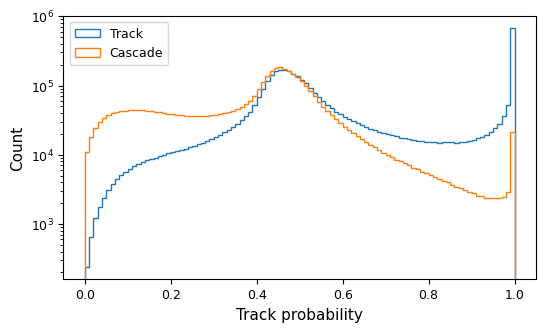

In [40]:

fig, axs = plt.subplots(figsize=set_size('thesis'))
#print(track_cascade.head(10))
hist = axs.hist(equal_track_cascade['track_mu_pred'][equal_track_cascade['track_mu'] == 1],bins=100,alpha=1,label='Track',histtype='step')
hist = axs.hist(equal_track_cascade['track_mu_pred'][equal_track_cascade['track_mu'] == 0],bins=100,alpha=1,label='Cascade',histtype='step')

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Track probability')
axs.legend(loc='upper left')

fig.tight_layout()
fig.savefig(outdir + 'track_probability_MC_equal.png',bbox_inches='tight',dpi=200)

In [41]:

predictions = []
truth = equal_track_cascade['track_mu'].values

number = len(equal_track_cascade)

for i in range(number):# range(len(results)):
    track_pred = equal_track_cascade['track_mu_pred'].values[i]
    pred = 0
    if track_pred > 0.5:
        pred = 1
    predictions.append(pred)




confusion_matrix_track = metrics.confusion_matrix(truth, predictions)

fpr_track, tpr_track , _ = metrics.roc_curve(truth,equal_track_cascade['track_mu_pred'].values,pos_label=1)

auc_track = metrics.auc(fpr_track, tpr_track)

In [42]:
predictions_0_to_1 = []
truth_0_to_1 = equal_track_cascade_0_to_1['track_mu'].values

number_0_to_1 = len(equal_track_cascade_0_to_1)

for i in range(number_0_to_1):# range(len(results)):
    track_pred_0_to_1 = equal_track_cascade_0_to_1['track_mu_pred'].values[i]
    pred_0_to_1 = 0
    if track_pred_0_to_1 > 0.5:
        pred_0_to_1 = 1
    predictions_0_to_1.append(pred_0_to_1)




confusion_matrix_track_0_to_1 = metrics.confusion_matrix(truth_0_to_1, predictions_0_to_1)

fpr_track_0_to_1, tpr_track_0_to_1 , _ = metrics.roc_curve(truth_0_to_1,equal_track_cascade_0_to_1['track_mu_pred'].values,pos_label=1)

auc_track_0_to_1 = metrics.auc(fpr_track_0_to_1, tpr_track_0_to_1)

In [43]:
predictions_1_to_2 = []
truth_1_to_2 = equal_track_cascade_1_to_2['track_mu'].values

number_1_to_2 = len(equal_track_cascade_1_to_2)

for i in range(number_1_to_2):# range(len(results)):
    track_pred_1_to_2 = equal_track_cascade_1_to_2['track_mu_pred'].values[i]
    pred_1_to_2 = 0
    if track_pred_1_to_2 > 0.5:
        pred_1_to_2 = 1
    predictions_1_to_2.append(pred_1_to_2)




confusion_matrix_track_1_to_2 = metrics.confusion_matrix(truth_1_to_2, predictions_1_to_2)

fpr_track_1_to_2, tpr_track_1_to_2 , _ = metrics.roc_curve(truth_1_to_2,equal_track_cascade_1_to_2['track_mu_pred'].values,pos_label=1)

auc_track_1_to_2 = metrics.auc(fpr_track_1_to_2, tpr_track_1_to_2)

In [44]:
predictions_2_to_3 = []
truth_2_to_3 = equal_track_cascade_2_to_3['track_mu'].values

number_2_to_3 = len(equal_track_cascade_2_to_3)

for i in range(number_2_to_3):# range(len(results)):
    track_pred_2_to_3 = equal_track_cascade_2_to_3['track_mu_pred'].values[i]
    pred_2_to_3 = 0
    if track_pred_2_to_3 > 0.5:
        pred_2_to_3 = 1
    predictions_2_to_3.append(pred_2_to_3)




confusion_matrix_track_2_to_3 = metrics.confusion_matrix(truth_2_to_3, predictions_2_to_3)

fpr_track_2_to_3, tpr_track_2_to_3 , _ = metrics.roc_curve(truth_2_to_3,equal_track_cascade_2_to_3['track_mu_pred'].values,pos_label=1)

auc_track_2_to_3 = metrics.auc(fpr_track_2_to_3, tpr_track_2_to_3)

In [45]:
predictions_3_to_4 = []
truth_3_to_4 = equal_track_cascade_3_to_4['track_mu'].values

number_3_to_4 = len(equal_track_cascade_3_to_4)

for i in range(number_3_to_4):# range(len(results)):
    track_pred_3_to_4 = equal_track_cascade_3_to_4['track_mu_pred'].values[i]
    pred_3_to_4 = 0
    if track_pred_3_to_4 > 0.5:
        pred_3_to_4 = 1
    predictions_3_to_4.append(pred_3_to_4)




confusion_matrix_track_3_to_4 = metrics.confusion_matrix(truth_3_to_4, predictions_3_to_4)

fpr_track_3_to_4, tpr_track_3_to_4 , _ = metrics.roc_curve(truth_3_to_4,equal_track_cascade_3_to_4['track_mu_pred'].values,pos_label=1)

auc_track_3_to_4 = metrics.auc(fpr_track_3_to_4, tpr_track_3_to_4)

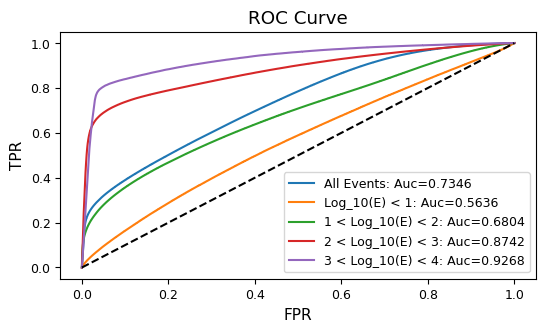

In [46]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# fig, axs = plt.subplots(figsize=set_size('thesis'))
# cm_display_track = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_track, display_labels = ['Cascade','Track'])
# cm_display_track.plot(ax=axs)

# for labels in cm_display.text_.ravel():
#     labels.set_fontsize(9)
# axs.set_ylabel('True')
# axs.set_xlabel('Predicted')


#fig.savefig(outdir+ 'Confusion_matrix_Multiclass_MC.pdf', format='pdf', bbox_inches='tight')


fig, axs = plt.subplots(1,1,figsize=set_size('thesis'))

axs.plot(fpr_track, tpr_track, label=f'All Events: Auc={auc_track:.4f}')
axs.plot(fpr_track_0_to_1, tpr_track_0_to_1, label=f'Log_10(E) < 1: Auc={auc_track_0_to_1:.4f}')
axs.plot(fpr_track_1_to_2, tpr_track_1_to_2, label=f'1 < Log_10(E) < 2: Auc={auc_track_1_to_2:.4f}')
axs.plot(fpr_track_2_to_3, tpr_track_2_to_3, label=f'2 < Log_10(E) < 3: Auc={auc_track_2_to_3:.4f}')
axs.plot(fpr_track_3_to_4, tpr_track_3_to_4, label=f'3 < Log_10(E) < 4: Auc={auc_track_3_to_4:.4f}')

axs.plot(np.linspace(0,1,100),np.linspace(0,1,100),linestyle='dashed',color='k')

axs.set_xlabel('FPR')
axs.set_ylabel('TPR')
#axs.set_xscale('log')
axs.set_title('ROC Curve')
axs.legend(loc='lower right')



fig.tight_layout()
fig.savefig(outdir+ 'ROC_Curves_track_cascade_MC.png', format='png', bbox_inches='tight',dpi=200)

#fig.savefig(outdir + 'Roc_curves.png')

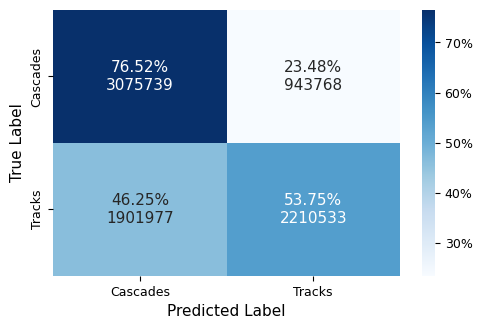

In [47]:
def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
    }   

    plt.rcParams.update(tex_fonts)
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    #sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d' % (p, c)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    fig.savefig(outdir+ 'confusion_matrix_track_cascade_MC.png', format='png', bbox_inches='tight',dpi=200)
    #plt.savefig(filename,  bbox_inches='tight')

cm_analysis(truth, predictions,'confusion_matrix',[0,1],['Cascades','Tracks'],figsize=set_size('thesis'))

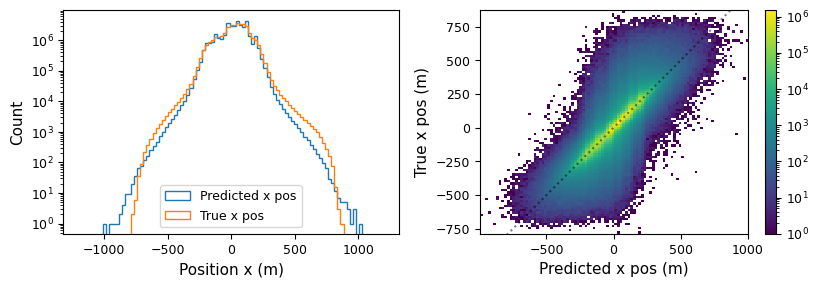

In [48]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_position = np.linspace(-1200,1200,100)
hist = axs[0].hist(MC['position_x_pred'],bins=bins_position,label='Predicted x pos',alpha=1,histtype='step')
hist = axs[0].hist(MC['position_x'],bins=bins_position,label='True x pos',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Position x (m)')
axs[0].set_yscale('log')
#axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(MC['position_x_pred'],MC['position_x'],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True x pos (m)')
axs[1].set_xlabel(r'Predicted x pos (m)')
zenith_line = np.linspace(-1000,1000,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'position_x_result_MC.png', format='png', bbox_inches='tight',dpi=200)

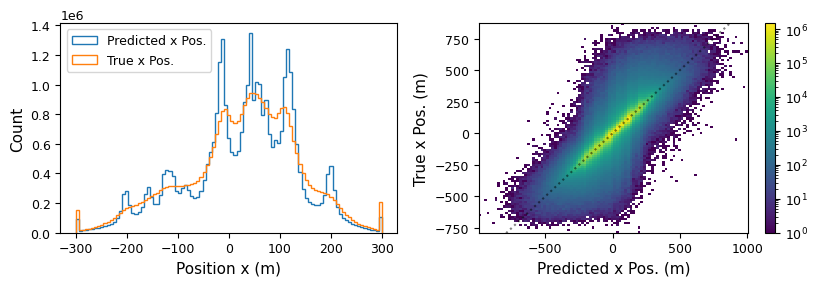

In [49]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_position = np.linspace(-300,300,100)
hist = axs[0].hist(np.clip(MC['position_x_pred'],-300,300),bins=bins_position,label='Predicted x Pos.',alpha=1,histtype='step')
hist = axs[0].hist(np.clip(MC['position_x'],-300,300),bins=bins_position,label='True x Pos.',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Position x (m)')
#axs[0].set_yscale('log')
#axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(MC['position_x_pred'],MC['position_x'],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True x Pos. (m)')
axs[1].set_xlabel(r'Predicted x Pos. (m)')
zenith_line = np.linspace(-1000,1000,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'position_x_result_MC_not_log.png', format='png', bbox_inches='tight',dpi=200)

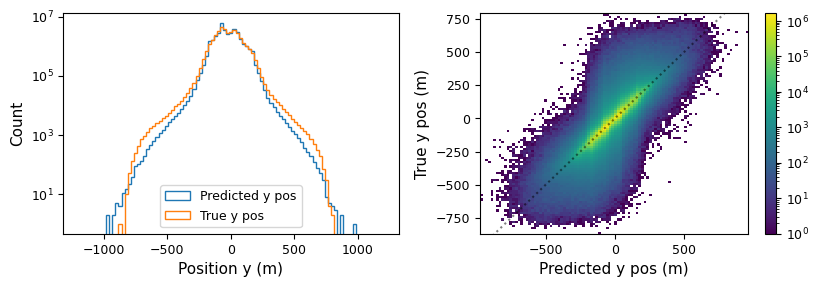

In [50]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_position = np.linspace(-1200,1200,100)
hist = axs[0].hist(MC['position_y_pred'],bins=bins_position,label='Predicted y pos',alpha=1,histtype='step')
hist = axs[0].hist(MC['position_y'],bins=bins_position,label='True y pos',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Position y (m)')
axs[0].set_yscale('log')
#axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(MC['position_y_pred'],MC['position_y'],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True y pos (m)')
axs[1].set_xlabel(r'Predicted y pos (m)')
zenith_line = np.linspace(-1000,1000,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'position_y_result_MC.png', format='png', bbox_inches='tight',dpi=200)

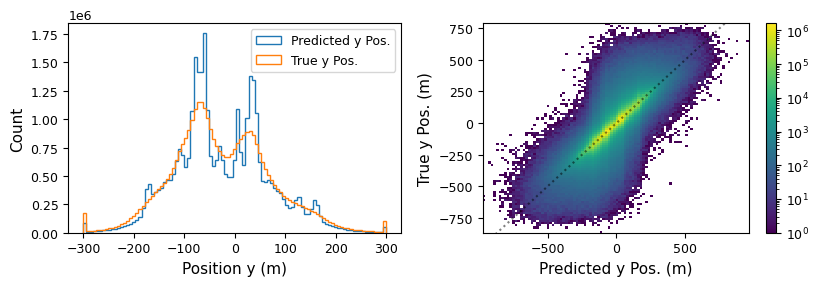

In [51]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_position = np.linspace(-300,300,100)
hist = axs[0].hist(np.clip(MC['position_y_pred'],-300,300),bins=bins_position,label='Predicted y Pos.',alpha=1,histtype='step')
hist = axs[0].hist(np.clip(MC['position_y'],-300,300),bins=bins_position,label='True y Pos.',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Position y (m)')
#axs[0].set_yscale('log')
#axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(MC['position_y_pred'],MC['position_y'],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True y Pos. (m)')
axs[1].set_xlabel(r'Predicted y Pos. (m)')
zenith_line = np.linspace(-1000,1000,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'position_y_result_MC_not_log.png', format='png', bbox_inches='tight',dpi=200)

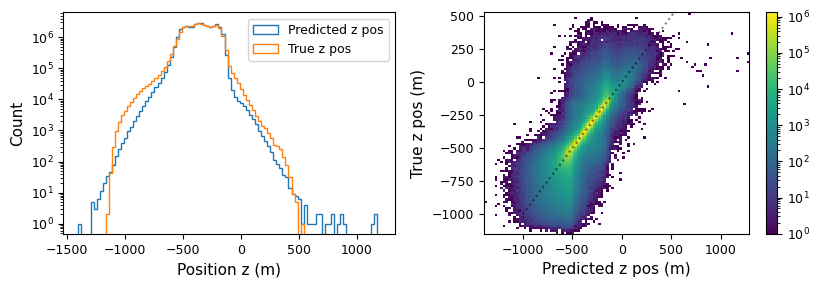

In [52]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_position = np.linspace(-1400,1200,100)
hist = axs[0].hist(MC['position_z_pred'],bins=bins_position,label='Predicted z pos',alpha=1,histtype='step')
hist = axs[0].hist(MC['position_z'],bins=bins_position,label='True z pos',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Position z (m)')
axs[0].set_yscale('log')
#axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(MC['position_z_pred'],MC['position_z'],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True z pos (m)')
axs[1].set_xlabel(r'Predicted z pos (m)')
zenith_line = np.linspace(-1000,1000,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)
fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'position_z_result_MC.png', format='png', bbox_inches='tight',dpi=200)

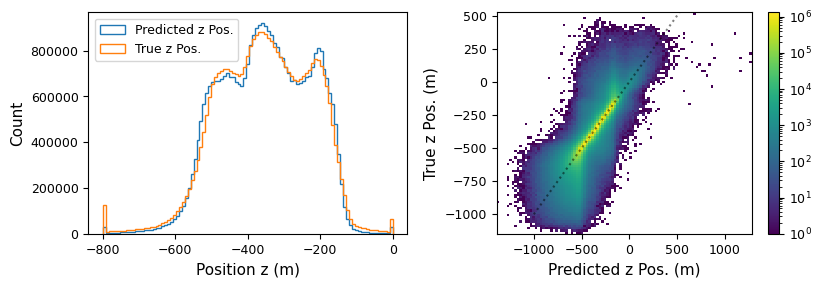

In [53]:
fig, axs = plt.subplots(1,2,figsize=set_size('thesis',fraction=1.5,subplots=(1,2),y_size=3))
bins_position = np.linspace(-800,0,100)
hist = axs[0].hist(np.clip(MC['position_z_pred'],-800,0),bins=bins_position,label='Predicted z Pos.',alpha=1,histtype='step')
hist = axs[0].hist(np.clip(MC['position_z'],-800,0),bins=bins_position,label='True z Pos.',alpha=1,histtype='step')
axs[0].set_ylabel('Count')
axs[0].set_xlabel(r'Position z (m)')
#axs[0].set_yscale('log')
#axs[0].set_ylim(top=10**8)
axs[0].legend()

hist = axs[1].hist2d(MC['position_z_pred'],MC['position_z'],bins=100,norm = colors.LogNorm())
axs[1].set_ylabel(r'True z Pos. (m)')
axs[1].set_xlabel(r'Predicted z Pos. (m)')
zenith_line = np.linspace(-1000,1000,100)
axs[1].plot(zenith_line,zenith_line,':',color='k',alpha=0.5)

fig.colorbar(hist[3],ax=axs[1])
fig.tight_layout()
fig.savefig(outdir+ 'position_z_result_MC_not_log.png', format='png', bbox_inches='tight',dpi=200)